In [1]:
!pip install minisom

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# !pip install minisom
from minisom import MiniSom

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

%matplotlib inline

In [3]:
def som_pie_grid(som, data, labels):
  """Helper to create piechart grid viz
  
  Example: https://raw.githubusercontent.com/JustGlowing/minisom/master/examples/resulting_images/som_iris_pies.png

  :param som: fitted MiniSom instance
  :param data: the data the MiniSom was fit to
  :param labels: an array of labels to use for coloring visual
  """
  labels_map = som.labels_map(data, labels)
  label_names = np.unique(labels)

  plt.figure(figsize=(70, 70))
  the_grid = GridSpec(70, 70)
  for position in labels_map.keys():
      label_fracs = [labels_map[position][lab] for lab in label_names]
      plt.subplot(the_grid[position[1] - 12, position[0]], aspect=1)
      patches, texts = plt.pie(label_fracs)

  plt.show()

  # Cheating way to align legend, create a separate figure just 
  # for legend.  Will have superfluous whitespace below
  plt.legend(patches, label_names, loc='upper left', ncol=5)
  plt.axis('off')
  plt.show()

* Read in the data from `data_url`
* Drop all NAs
* Filter based on the `'Pos'` column to where only have the positions `['C', 'PG', 'SG']` remain
* Drop all non-numeric columns
* Scale the data

In [4]:
data_url = "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Clustering/nba_player_seasons.csv"

In [5]:
nba = pd.read_csv(data_url)
print(nba.shape)
nba.head()

(2141, 30)


,Seas,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2019,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,1.3,4.1,0.323,0.5,1.0,0.500,0.487,0.4,0.4,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
1,2019,Quincy Acy,PF,28,PHO,10,0,12.3,0.4,1.8,0.222,0.2,1.5,0.133,0.2,0.3,0.667,0.278,0.7,1.0,0.700,0.3,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7
2,2019,Jaylen Adams,PG,22,ATL,34,1,12.6,1.1,3.2,0.345,0.7,2.2,0.338,0.4,1.1,0.361,0.459,0.2,0.3,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
3,2019,Steven Adams,C,25,OKC,80,80,33.4,6.0,10.1,0.595,0.0,0.0,0.000,6.0,10.1,0.596,0.595,1.8,3.7,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
4,2019,Bam Adebayo,C,21,MIA,82,28,23.3,3.4,5.9,0.576,0.0,0.2,0.200,3.4,5.7,0.588,0.579,2.0,2.8,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9


In [6]:
#nulls
nulls = nba.isnull().sum() / nba.isnull().count()
nulls.loc[nulls > 0]

FG%     0.004671
3P%     0.081270
2P%     0.014479
eFG%    0.004671
FT%     0.048575
dtype: float64

In [7]:
#dropping nulls
nba = nba.dropna()

In [8]:
#filtering position 
#C, PG, SG
df = nba.loc[nba['Pos'].isin(['C', 'PG', 'SG'])]
df.shape

(1154, 30)

In [9]:
df.reset_index(drop=True)

,Seas,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2019,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,1.3,4.1,0.323,0.5,1.0,0.500,0.487,0.4,0.4,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
1,2019,Jaylen Adams,PG,22,ATL,34,1,12.6,1.1,3.2,0.345,0.7,2.2,0.338,0.4,1.1,0.361,0.459,0.2,0.3,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
2,2019,Steven Adams,C,25,OKC,80,80,33.4,6.0,10.1,0.595,0.0,0.0,0.000,6.0,10.1,0.596,0.595,1.8,3.7,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
3,2019,Bam Adebayo,C,21,MIA,82,28,23.3,3.4,5.9,0.576,0.0,0.2,0.200,3.4,5.7,0.588,0.579,2.0,2.8,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9
4,2019,DeVaughn Akoon-Purcell,SG,25,DEN,7,0,3.1,0.4,1.4,0.300,0.0,0.6,0.000,0.4,0.9,0.500,0.300,0.1,0.3,0.500,0.1,0.4,0.6,0.9,0.3,0.0,0.3,0.6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,2016,Tony Wroten,PG,22,PHI,8,3,18.0,2.8,8.1,0.338,0.4,2.1,0.176,2.4,6.0,0.396,0.362,2.5,4.6,0.541,0.3,2.4,2.6,2.5,0.4,0.0,3.6,1.4,8.4
1150,2016,James Young,SG,20,BOS,29,0,6.9,0.4,1.2,0.306,0.2,0.9,0.231,0.2,0.3,0.500,0.389,0.0,0.1,0.250,0.1,0.8,0.9,0.3,0.2,0.0,0.2,0.6,1.0
1151,2016,Joe Young,PG,23,IND,41,0,9.4,1.5,4.1,0.367,0.2,1.1,0.217,1.3,3.0,0.423,0.396,0.5,0.6,0.800,0.1,1.1,1.2,1.6,0.4,0.0,0.8,0.7,3.8
1152,2016,Nick Young,SG,30,LAL,54,2,19.1,2.3,6.9,0.339,1.4,4.4,0.325,0.9,2.5,0.363,0.442,1.2,1.4,0.829,0.3,1.5,1.8,0.6,0.4,0.1,0.6,0.9,7.3


In [10]:
#dropping non-numeric
X = df.select_dtypes(exclude='O')
y = df.Pos

In [11]:
#scaling data
scale = StandardScaler()
X_scale = scale.fit_transform(X)

* Fit a `MiniSom` instance to the scaled data
  * Choose your own grid size
  * Set a `random_seed` to have reproducible results
  * Initialize the `MiniSom` weight vectors using `.pca_weights_init()` or `.random_weights_init()`
  * Train the model using `.train_random()` or `.train_batch()`

In [12]:
n_cols = X_scale.shape[1]

In [13]:
grid_cols = 12
grid_rows = 8

som = MiniSom(x=grid_cols, y=grid_rows, input_len=n_cols, random_seed=55)
som.pca_weights_init(X_scale)
som.train_random(X_scale, num_iteration=100)

In [14]:
win_x = []
win_y = []
win_ids = []

for row in range(len(X_scale)):
  winner_x, winner_y = som.winner(X_scale[row])
  win_x.append(winner_x)
  win_y.append(winner_y)
  win_ids.append((winner_x, winner_y))

win_df = pd.DataFrame({'winner_x': win_x, 'winner_y': win_y, 'winner_ids': win_ids})

In [15]:
win_df['Pos'] = df['Pos']

In [16]:
win_df

,winner_x,winner_y,winner_ids,Pos
0,4,2,"(4, 2)",SG
1,3,1,"(3, 1)",NaN
2,0,7,"(0, 7)",PG
3,1,5,"(1, 5)",C
4,1,0,"(1, 0)",C
...,...,...,...,...
1149,9,0,"(9, 0)",NaN
1150,1,0,"(1, 0)",NaN
1151,0,1,"(0, 1)",PG
1152,4,0,"(4, 0)",PG


* Use the helper function defined at the top of the notebook to plot the SOM's fit
  * Use the players' positions (the `'Pos'` column) as the labels in the viz
  * Experiment with the SOM's grid size, initialization method, and training method.  Decide a 'good' fit using this visual as guidance.

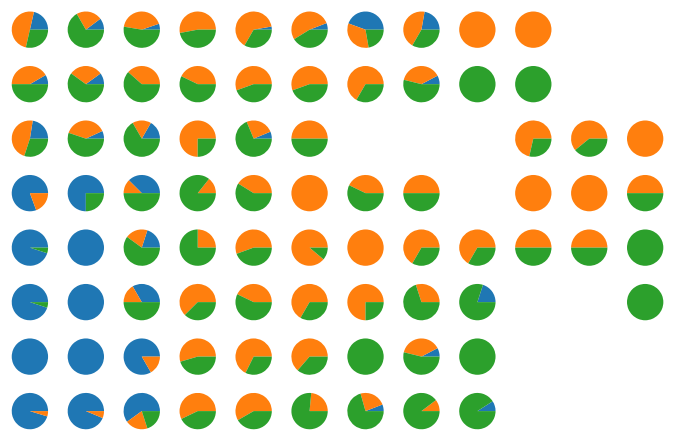

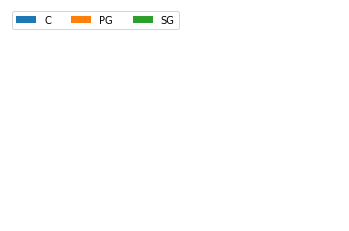

In [17]:
som_pie_grid(som, X_scale, y)

* Perform dimension reduction (to 2d) with another method (perhaps `PCA` or `TSNE`).
* Create a scatter plot of the results of this dimension reduction and color the scatter plot by the players' positions (the `'Pos'` column).
  * How do these results compare to that of the SOM? What are the pros and cons of the different approaches you took in this notebook?

In [21]:
tsne = TSNE(n_components=2, perplexity=40 ,verbose=1)
tsne_comps = tsne.fit_transform(X_scale)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1154 samples in 0.004s...
[t-SNE] Computed neighbors for 1154 samples in 0.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1154
[t-SNE] Computed conditional probabilities for sample 1154 / 1154
[t-SNE] Mean sigma: 1.409056
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.818123
[t-SNE] KL divergence after 1000 iterations: 1.057057


In [29]:
import plotly.express as px
px.scatter(x=tsne_comps[:,0], y=tsne_comps[:,1], color=y)

*results look somewhat similar with one class being almost seperate from the other two (very little inter-mix). While the other 2 classes are not easily seperable.*